# Жанровая классификация аудио

In [1]:
import json
import glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa

import torch
import torch.mps
import tensorflow as tf
import keras

import torchsummary as ts

from functools import reduce
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import NuSVC
from sklearn.metrics import log_loss
from scipy.optimize import minimize_scalar
from keras.backend import clear_session
from keras.callbacks import TensorBoard, ModelCheckpoint, CSVLogger, BackupAndRestore

from utils import label2vec

%load_ext autoreload
%autoreload 2

2023-04-28 13:23:50.210227: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 13:23:51.388677: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Проверим, что GPU доступно для вычислений

In [2]:
print(tf.config.list_physical_devices())
print(f'MPS is available: {torch.backends.mps.is_available()}')
print(f'MPS is built: {torch.backends.mps.is_built()}')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
MPS is available: False
MPS is built: False


2023-04-28 13:23:52.933279: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-28 13:23:53.042888: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-28 13:23:53.043469: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Фильтрация метаданных

In [3]:
DATA_DIR = './data/fma_small'
METADATA_DIR = './data/fma_metadata/'

mp3_files = glob.glob(DATA_DIR + '/*/*.mp3')
mp3_names = list(map(lambda f: np.int64(f.split('/')[-1].split('.')[0]), mp3_files))

raw_tracks = pd.read_csv(METADATA_DIR + 'raw_tracks.csv')
tracks = raw_tracks[raw_tracks['track_id'].isin(mp3_names)]

## Сбор признаков, полученных с помощью `librosa`

В качестве метаданных для аудио будем использовать уже собранный набор данных

In [4]:
features_df = pd.read_csv(METADATA_DIR + 'features.csv', index_col=0, header=[0, 1, 2])
features_df = features_df[features_df.index.isin(mp3_names)]

features = np.unique(list(map(lambda x: x[0], list(features_df.columns))))

print(f"Features available: {features}")
print(f"Total: {len(features)}")

features_df

Features available: ['chroma_cens' 'chroma_cqt' 'chroma_stft' 'mfcc' 'rmse'
 'spectral_bandwidth' 'spectral_centroid' 'spectral_contrast'
 'spectral_rolloff' 'tonnetz' 'zcr']
Total: 11


feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
5             0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10            3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
140           0.533579 -0.623885 -1.086205 -1.081079 -0.765151 -0.072282   
141           0.172898 -0.284804 -1.169662 -1.062855 -0.706868 -0.708281   
...                ...       ...       ...       ...       ...       ...   
154308       -0.677709 -0.830608 -0.686122  0.185158  2.854806 -1.131797   
154309       -0.585059 -0.635075 -0.194742 -0.434809 -1.357310 -0.257745   
154413       -0.214509 -1.130469  0.718534 -0.368448 -0.147830 -0.099409   
154414       -0.487371 -0.923754 -0.283099 -0.435221 -1.137329 -0.798039   
155066        0.044216 -0.300441 -0.217022 -0.356106 -1.085789 -1.185135   

feature                                             ...   tonnetz            \
statistics                                          ...       std             
number            07        08        09        10  ...        04        05   
track_id                                            ...                       
2           1.481593  2.691455  0.866868  1.341231  ...  0.054125  0.012226   
5          -0.923192 -0.927232  0.666617  1.038546  ...  0.040730  0.012691   
10          1.770694  1.604566  0.521217  1.982386  ...  0.074358  0.017952   
140        -0.882913 -0.582376 -0.884749 -0.645214  ...  0.157683  0.028070   
141        -0.204884  0.023624 -0.642770 -0.786291  ...  0.145994  0.024342   
...              ...       ...       ...       ...  ...       ...       ...   
154308     -1.161222 -1.110237 -0.818111 -1.388484  ...  0.117287  0.021906   
154309     -0.639082 -0.572640 -1.225242  5.548715  ...  0.180397  0.029303   
154413     -1.325709 -0.105248 -1.363881  1.229534  ...  0.156587  0.036926   
154414     -0.258168  1.004049 -0.499121  0.746973  ...  0.181294  0.026723   
155066     -0.655948 -1.517006 -0.490595 -1.267883  ...  0.189816  0.029439   

feature                      zcr                                          \
statistics              kurtosis       max      mean    median       min   
number            06          01        01        01        01        01   
track_id                                                                   
2           0.012111    5.758890  0.459473  0.085629  0.071289  0.000000   
5           0.014759    6.808415  0.375000  0.053114  0.041504  0.000000   
10          0.013921   21.434212  0.452148  0.077515  0.071777  0.000000   
140         0.025946   11.052547  0.379395  0.052379  0.036621  0.001953   
141         0.032111   32.994659  0.415527  0.040267  0.034668  0.002930   
...              ...         ...       ...       ...       ...       ...   
154308      0.021999   53.807804  0.769043  0.042997  0.022949  0.001953   
154309      0.023771   12.597441  0.768555  0.082979  0.037109  0.008789   
154413      0.038113   25.368595  0.323242  0.024532  0.018066  0.000977   
154414      0.030980   21.276468  0.511230  0.046116  0.033691  0.003418   
155066      0.025806  116.044044  0.554199  0.016058  0.009766  0.000000   

feature                         
statistics      skew       std  
number            01        01  
track_id                        
2           2.089872  0.061448  
5           2.193303  0.044861  
10          3.542325  0.040800  
140         3.143968  0.057712  
141         4.204097  0.028665  
...              ...       ...  
154308      6.928385  0.084298  
154309      3.441251  0.129480  
154413      3.736646  0.023821  
154414      3.997052  0.045733  
155066      9.688635  0.030787  

[8000 rows x 518 columns]

## Отбор признаков

Рассмотрим всю имеющуюся информацию о треках

In [5]:
len(tracks.columns)

39

Оценим число непустых значений тегов

In [6]:
tracks['tags'].map(lambda x: None if x == '[]' else x).notnull().value_counts()

False    6639
True     1361
Name: tags, dtype: int64

Подсчитаем число уникальных тегов

In [7]:
unique_tags = reduce(lambda tags, l: tags.union(eval(l)), tracks['tags'], set())
print(len(unique_tags))

1191


Оставим предположительно полезную информацию из набора данных. Убедимся
в её необходимости позже.

In [8]:
to_keep = [
  'track_id', "album_id", "artist_id", "track_duration", 
  "track_genres", "track_instrumental", "track_interest", "track_listens",
]

filtered_tracks = tracks[to_keep]
filtered_tracks

,track_id,album_id,artist_id,track_duration,track_genres,track_instrumental,track_interest,track_listens
0,2,1.0,1,02:48,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",0,4656,1293
2,5,1.0,1,03:26,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",0,1933,1151
3,10,6.0,6,02:41,"[{'genre_id': '10', 'genre_title': 'Pop', 'gen...",0,54881,50135
15,140,61.0,54,04:13,"[{'genre_id': '17', 'genre_title': 'Folk', 'ge...",0,1593,1299
16,141,60.0,54,03:02,"[{'genre_id': '17', 'genre_title': 'Folk', 'ge...",0,839,725
...,...,...,...,...,...,...,...,...
108843,154308,22780.0,23208,03:14,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",0,3371,2705
108844,154309,22780.0,23208,02:42,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",0,4525,3589
108945,154413,22789.0,24252,05:49,"[{'genre_id': '76', 'genre_title': 'Experiment...",0,809,676
108946,154414,22789.0,24252,05:46,"[{'genre_id': '76', 'genre_title': 'Experiment...",0,851,788


Преобразуем время в секунды

In [9]:
def duration_to_int(t):
  splitted = t.split(":")
  
  return int(splitted[0]) * 60 + int(splitted[1])

filtered_tracks.loc[:,'track_duration'] = filtered_tracks.track_duration.apply(duration_to_int)
filtered_tracks

/tmp/ipykernel_705/3619144929.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_tracks.loc[:,'track_duration'] = filtered_tracks.track_duration.apply(duration_to_int)
/tmp/ipykernel_705/3619144929.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  filtered_tracks.loc[:,'track_duration'] = filtered_tracks.track_duration.apply(duration_to_int)


,track_id,album_id,artist_id,track_duration,track_genres,track_instrumental,track_interest,track_listens
0,2,1.0,1,168,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",0,4656,1293
2,5,1.0,1,206,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",0,1933,1151
3,10,6.0,6,161,"[{'genre_id': '10', 'genre_title': 'Pop', 'gen...",0,54881,50135
15,140,61.0,54,253,"[{'genre_id': '17', 'genre_title': 'Folk', 'ge...",0,1593,1299
16,141,60.0,54,182,"[{'genre_id': '17', 'genre_title': 'Folk', 'ge...",0,839,725
...,...,...,...,...,...,...,...,...
108843,154308,22780.0,23208,194,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",0,3371,2705
108844,154309,22780.0,23208,162,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",0,4525,3589
108945,154413,22789.0,24252,349,"[{'genre_id': '76', 'genre_title': 'Experiment...",0,809,676
108946,154414,22789.0,24252,346,"[{'genre_id': '76', 'genre_title': 'Experiment...",0,851,788


Узнаем количество жанров для треков

In [10]:
genres = filtered_tracks['track_genres'].map(lambda x: json.loads(x.replace("'", "\"")))
genre_ids = genres.map(lambda x: list(map(lambda y: y['genre_id'], x)))
genre_ids.map(lambda x: len(x)).value_counts()

1    4256
2    2362
3    1304
4      41
5      32
6       5
Name: track_genres, dtype: int64

Определим базовые жанры для каждого трека

In [11]:
all_genres = pd.read_csv(METADATA_DIR + 'genres.csv')

base_genres = genre_ids.map(lambda x: all_genres[all_genres.genre_id == int(x[0])].iloc[0].top_level)

filtered_tracks['track_genres'] = base_genres
filtered_tracks

/tmp/ipykernel_705/3932000545.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_tracks['track_genres'] = base_genres


,track_id,album_id,artist_id,track_duration,track_genres,track_instrumental,track_interest,track_listens
0,2,1.0,1,168,21,0,4656,1293
2,5,1.0,1,206,21,0,1933,1151
3,10,6.0,6,161,10,0,54881,50135
15,140,61.0,54,253,17,0,1593,1299
16,141,60.0,54,182,17,0,839,725
...,...,...,...,...,...,...,...,...
108843,154308,22780.0,23208,194,21,0,3371,2705
108844,154309,22780.0,23208,162,21,0,4525,3589
108945,154413,22789.0,24252,349,10,0,809,676
108946,154414,22789.0,24252,346,10,0,851,788


In [12]:
base_genres.value_counts()

21      1000
10      1000
17      1000
38      1000
12      1000
2       1000
15      1000
1235    1000
Name: track_genres, dtype: int64

Получили 8 сбалансированных классов

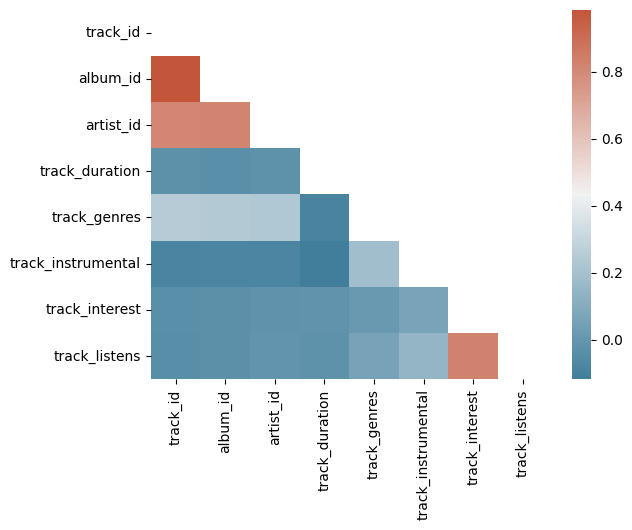

In [13]:
def display_corr(df):
  corr = df.corr()
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  mask = np.triu(np.ones_like(corr, dtype=bool))
  sns.heatmap(corr, mask=mask, cmap=cmap)
  
display_corr(filtered_tracks)

Жанр трека очень плохо коррелирует с его длительностью, поэтому исключим
этот признак из рассмотрения

In [14]:
filtered_tracks = filtered_tracks.drop('track_duration', axis=1)

Теперь добавим значения, предпосчитанные с помощью `librosa`

/tmp/ipykernel_705/1369159907.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (3 levels on the left, 1 on the right)
  merged = features_df.merge(filtered_tracks, how='inner', on='track_id')


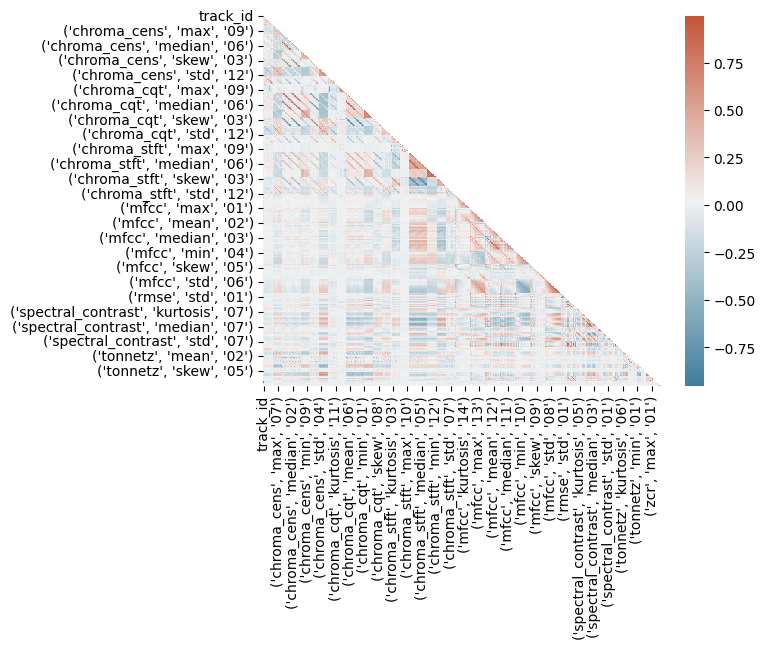

In [15]:
merged = features_df.merge(filtered_tracks, how='inner', on='track_id')

display_corr(merged)

In [16]:
merged

,track_id,"(chroma_cens, kurtosis, 01)","(chroma_cens, kurtosis, 02)","(chroma_cens, kurtosis, 03)","(chroma_cens, kurtosis, 04)","(chroma_cens, kurtosis, 05)","(chroma_cens, kurtosis, 06)","(chroma_cens, kurtosis, 07)","(chroma_cens, kurtosis, 08)","(chroma_cens, kurtosis, 09)",...,"(zcr, median, 01)","(zcr, min, 01)","(zcr, skew, 01)","(zcr, std, 01)",album_id,artist_id,track_genres,track_instrumental,track_interest,track_listens
0,2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,...,0.071289,0.000000,2.089872,0.061448,1.0,1,21,0,4656,1293
1,5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,...,0.041504,0.000000,2.193303,0.044861,1.0,1,21,0,1933,1151
2,10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,...,0.071777,0.000000,3.542325,0.040800,6.0,6,10,0,54881,50135
3,140,0.533579,-0.623885,-1.086205,-1.081079,-0.765151,-0.072282,-0.882913,-0.582376,-0.884749,...,0.036621,0.001953,3.143968,0.057712,61.0,54,17,0,1593,1299
4,141,0.172898,-0.284804,-1.169662,-1.062855,-0.706868,-0.708281,-0.204884,0.023624,-0.642770,...,0.034668,0.002930,4.204097,0.028665,60.0,54,17,0,839,725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,154308,-0.677709,-0.830608,-0.686122,0.185158,2.854806,-1.131797,-1.161222,-1.110237,-0.818111,...,0.022949,0.001953,6.928385,0.084298,22780.0,23208,21,0,3371,2705
7996,154309,-0.585059,-0.635075,-0.194742,-0.434809,-1.357310,-0.257745,-0.639082,-0.572640,-1.225242,...,0.037109,0.008789,3.441251,0.129480,22780.0,23208,21,0,4525,3589
7997,154413,-0.214509,-1.130469,0.718534,-0.368448,-0.147830,-0.099409,-1.325709,-0.105248,-1.363881,...,0.018066,0.000977,3.736646,0.023821,22789.0,24252,10,0,809,676
7998,154414,-0.487371,-0.923754,-0.283099,-0.435221,-1.137329,-0.798039,-0.258168,1.004049,-0.499121,...,0.033691,0.003418,3.997052,0.045733,22789.0,24252,10,0,851,788


Конечно, признаков слишком много. Из всех возьмем признаки с наибольшей по
модулю корреляцией.

Для этого отсортируем признаки по степени корреляции

In [17]:
correlation = merged.corr()

genres_corr = correlation['track_genres'].sort_values(key=lambda x: np.abs(x), ascending=False)
genres_corr

track_genres                        1.000000
(spectral_bandwidth, median, 01)   -0.340123
(spectral_bandwidth, mean, 01)     -0.335322
(mfcc, mean, 01)                   -0.331284
(spectral_contrast, mean, 07)      -0.328257
                                      ...   
(chroma_cens, kurtosis, 10)         0.001003
(mfcc, skew, 18)                    0.000923
(chroma_cens, skew, 09)             0.000667
(mfcc, median, 09)                  0.000328
(chroma_cens, kurtosis, 03)         0.000273
Name: track_genres, Length: 525, dtype: float64

Изобразим распределение значений корреляции

<Axes: xlabel='track_genres', ylabel='Count'>

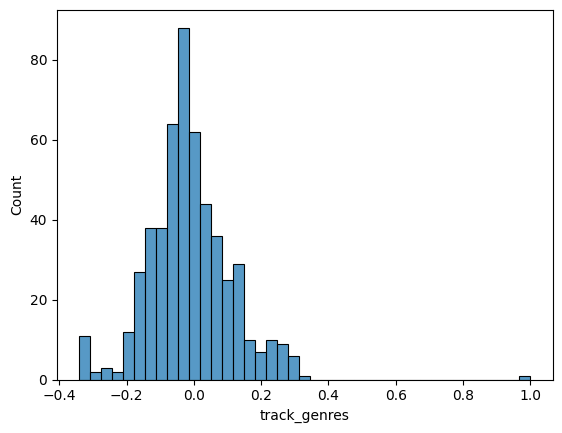

In [18]:
sns.histplot(genres_corr)

Видно, что наибольшее число признаков имеют почти нулевую корреляцию.
В связи с этим выберем наиболее информативные из них

In [19]:
boundary = 0.2

selected = merged[genres_corr[abs(genres_corr) > boundary].reset_index()['index']]
selected.set_index('track_id', inplace=True)

Кроме того, удалим сильно коррелирующие друг с другом нецелевые признаки,
оставив среди таких пар те, что больше коррелируют с целевым

In [20]:
c = selected.corr()

to_be_excluded = set()

boundary = 0.9

for i in c:
  for j in c:
    if abs(c[i][j]) > boundary and i != j and i != 'track_genres' and j != 'track_genres':
      least_informative = i if c['track_genres'][i] < c['track_genres'][j] else j
      to_be_excluded.add(least_informative)
      
to_be_excluded

{('mfcc', 'mean', '01'),
 ('mfcc', 'mean', '02'),
 ('mfcc', 'mean', '04'),
 ('mfcc', 'median', '03'),
 ('mfcc', 'median', '06'),
 ('spectral_bandwidth', 'mean', '01'),
 ('spectral_bandwidth', 'median', '01'),
 ('spectral_centroid', 'mean', '01'),
 ('spectral_centroid', 'median', '01'),
 ('spectral_centroid', 'skew', '01'),
 ('spectral_contrast', 'mean', '07'),
 ('spectral_contrast', 'median', '02'),
 ('spectral_contrast', 'median', '03'),
 ('spectral_contrast', 'median', '04'),
 ('spectral_rolloff', 'mean', '01')}

In [21]:
selected = selected.drop(to_be_excluded, axis=1)

Перекодируем метки классов

In [22]:
genre_le = LabelEncoder()

selected.track_genres = genre_le.fit_transform(selected.track_genres)
selected

,track_genres,"(mfcc, median, 01)","(spectral_rolloff, skew, 01)","(spectral_contrast, median, 07)","(mfcc, max, 01)","(spectral_rolloff, median, 01)","(spectral_bandwidth, skew, 01)","(spectral_contrast, max, 07)","(mfcc, max, 04)","(spectral_contrast, mean, 03)",...,artist_id,"(tonnetz, std, 04)","(mfcc, min, 03)","(mfcc, min, 07)","(mfcc, max, 02)","(spectral_contrast, mean, 02)","(mfcc, max, 08)","(zcr, mean, 01)","(rmse, mean, 01)","(mfcc, mean, 06)"
track_id,,,,,,,,,,,,,,,,,,,,,
2,5,-143.594299,0.347372,39.830345,28.657707,3143.847656,-0.884317,54.687260,103.289833,17.129013,...,1,0.054125,-115.315613,-61.748718,215.541351,15.363138,58.169933,0.085629,3.188761,18.879372
5,5,-181.015961,0.266975,39.101978,-40.500740,2863.916016,-0.658707,51.896751,112.312531,18.646988,...,1,0.040730,-87.205124,-59.320251,218.972977,15.969444,57.987415,0.053114,3.251386,16.942802
10,1,-113.085472,1.800220,36.594524,20.196968,2002.587891,0.878823,52.130795,78.466721,15.510051,...,6,0.074358,-130.033524,-44.849060,235.198517,14.281867,42.955067,0.077515,3.893810,13.934344
140,4,-200.058487,0.655808,37.852184,-19.554893,2153.320312,0.091172,52.635704,148.336426,18.562231,...,54,0.157683,-91.350792,-68.356682,218.817322,16.298210,51.864899,0.052379,2.953848,28.328743
141,4,-259.161804,1.430542,31.146515,-31.971275,1658.056641,1.004211,49.282562,108.459908,19.953085,...,54,0.145994,-88.630844,-58.395340,232.621674,18.583612,50.200264,0.040267,2.576761,11.692952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154308,5,-296.399994,2.989810,21.365528,10.407327,1152.026367,1.310098,46.864613,124.703125,19.874151,...,23208,0.117287,-178.103043,-31.414083,283.707458,16.733612,38.486408,0.042997,2.174565,4.368904
154309,5,-388.301178,0.994214,23.360811,-21.851103,1130.493164,0.350365,54.186939,82.278091,22.690062,...,23208,0.180397,-101.862770,-56.105015,269.592011,19.529175,50.166153,0.082979,1.548146,1.173940
154413,1,-224.460236,1.316305,32.489326,-57.707806,1475.024414,1.262819,51.684505,153.485001,20.002176,...,24252,0.156587,-80.218735,-56.207314,238.620834,17.922699,66.826797,0.024532,4.202268,22.758905


In [23]:
selected.columns = selected.columns.map(str)

In [29]:
for column in selected.columns:
  if column == 'track_genres':
    continue
  selected[column] = StandardScaler().fit_transform(selected[column].to_numpy().reshape(-1, 1))

Убедимся, что `StandardScaler` отработал корректно

In [30]:
selected.describe()

,track_genres,"('mfcc', 'median', '01')","('spectral_rolloff', 'skew', '01')","('spectral_contrast', 'median', '07')","('mfcc', 'max', '01')","('spectral_rolloff', 'median', '01')","('spectral_bandwidth', 'skew', '01')","('spectral_contrast', 'max', '07')","('mfcc', 'max', '04')","('spectral_contrast', 'mean', '03')",...,artist_id,"('tonnetz', 'std', '04')","('mfcc', 'min', '03')","('mfcc', 'min', '07')","('mfcc', 'max', '02')","('spectral_contrast', 'mean', '02')","('mfcc', 'max', '08')","('zcr', 'mean', '01')","('rmse', 'mean', '01')","('mfcc', 'mean', '06')"
count,8000.000000,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,...,8.000000e+03,8.000000e+03,8.000000e+03,8000.000000,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03
mean,3.500000,-1.243450e-17,-2.131628e-17,-1.776357e-18,-1.065814e-17,7.105427e-18,-1.421085e-17,-7.105427e-18,1.598721e-17,1.421085e-17,...,5.684342e-17,-7.105427e-18,1.421085e-17,0.000000,-1.065814e-17,1.421085e-17,5.329071e-18,-7.105427e-18,2.131628e-17,6.217249e-18
std,2.291431,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,...,1.000063e+00,1.000063e+00,1.000063e+00,1.000063,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00
min,0.000000,-7.970248e+00,-1.095442e+01,-2.623073e+00,-1.163158e+01,-1.652957e+00,-1.427370e+01,-4.579266e+00,-3.941956e+00,-3.390965e+00,...,-1.856327e+00,-2.412642e+00,-4.395684e+00,-6.406196,-8.931983e+00,-3.082066e+00,-3.479518e+00,-1.663026e+00,-1.838379e+00,-4.796596e+00
25%,1.750000,-6.038649e-01,-5.645684e-01,-5.836193e-01,-5.091851e-01,-7.247778e-01,-5.563256e-01,-4.197092e-01,-6.408750e-01,-7.028439e-01,...,-8.134367e-01,-7.401046e-01,-6.306006e-01,-0.604327,-5.412937e-01,-6.975963e-01,-6.282162e-01,-6.475547e-01,-7.376613e-01,-5.608036e-01
50%,3.500000,1.216726e-01,-2.553486e-01,1.403841e-01,2.018295e-01,-1.522561e-01,-1.888263e-01,2.130642e-01,4.682082e-02,-1.366630e-01,...,1.209327e-01,-1.195729e-01,3.934132e-03,0.064685,6.373809e-02,-1.353631e-01,-1.992645e-02,-1.668971e-01,-1.134209e-01,8.966895e-02
75%,5.250000,6.996039e-01,2.681449e-01,7.334416e-01,7.026321e-01,5.677334e-01,3.443690e-01,6.647770e-01,6.849368e-01,5.872362e-01,...,9.257628e-01,6.060888e-01,6.127545e-01,0.670297,6.547827e-01,5.682169e-01,6.146821e-01,4.183036e-01,5.811625e-01,6.707833e-01
max,7.000000,3.421958e+00,1.856961e+01,2.787234e+00,2.529067e+00,6.310300e+00,1.625224e+01,2.257328e+00,4.897631e+00,7.646116e+00,...,1.611062e+00,4.760091e+00,3.442668e+00,3.195089,3.130199e+00,7.374279e+00,9.095344e+00,2.032211e+01,6.857885e+00,4.062191e+00


In [26]:
selected.to_csv('data/selected.csv')

Разделим данные по принципу `train/test/split`

In [27]:
x = selected.drop('track_genres', axis=1).to_numpy()
y = selected['track_genres'].to_numpy()

test_size = 0.2
valid_size = 0.1

X_train, X_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.2, random_state=69, stratify=y)
    
X_train, X_valid, y_train, y_valid = \
    train_test_split(X_train, y_train, test_size=valid_size / (1 - test_size),
                     random_state=69, stratify=y_train)
    
n_classes = np.max(y) + 1

In [28]:
models = []

### K-Nearest Neighbours

In [ ]:
n_classes = np.max(y) + 1
list_of_neighbours = list(map(int, range(1, 300, 5)))

Опишем функцию, которая будет отображать результаты экспериментов

In [ ]:
def plot_score(n, scores, names):
    d = {names: n, 'score': scores}
    df = pd.DataFrame(d)

    sns.set(style='darkgrid')
    sns.lineplot(x=names, y='score', data=df)

Вычислим значения `accuracy` для моделей с разным числом соседей

In [ ]:
best_n = -1
best_score = -1
scores = []
for n in tqdm(list_of_neighbours):
    knn = KNeighborsClassifier(p=1, n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    score = knn.score(X_test, y_test)
    
    if score > best_score:
        best_score = score
        best_n = n
    scores.append(score)

plot_score(list_of_neighbours, scores, 'neighbors')
print(f'Лучшая модель: {best_n} соседей, точность: {best_score}')

Конечно, такой метод оценки качества модели не является надежным, лучше воспользоваться
оценкой методом кросс-валидации — `cross_val_score`.

В дальнейшем будем использовать именно этот метод.

In [ ]:
best_n = -1
best_score = -1
scores = []

for n in tqdm(list_of_neighbours):
    knn = KNeighborsClassifier(p=2, n_neighbors=n)
    
    score = cross_val_score(knn, x, y, cv=5).mean()
    
    if score > best_score:
        best_score = score
        best_n = n
    scores.append(score)

plot_score(list_of_neighbours, scores, 'neighbors')
print(f'Лучшая модель: {best_n} соседей, точность: {best_score}')

models.append((KNeighborsClassifier(p=2, n_neighbors=best_n), 'sklearn'))

In [ ]:
scores = []
for n in tqdm(list_of_neighbours):
    knn = KNeighborsClassifier(p=2, n_neighbors=n)
    knn.fit(X_train, y_train)
    probs = knn.predict_proba(X_test)
    
    loss = log_loss(y_test, probs)
    scores.append(loss)

plot_score(list_of_neighbours, scores, 'neighbors')

### $\nu$-svc

У $\nu$-svc есть несколько возможных для использования ядер:

- linear
- poly
- rbf
- sigmoid

Сравним их между собой

In [ ]:
kernels = ["linear", "poly", "rbf", "sigmoid"]
kernels_scores: dict[str, float] = {}
for kernel in tqdm(kernels):
    nu_svc = NuSVC(kernel=kernel)
    kernels_scores[kernel] = cross_val_score(nu_svc, x, y, cv=5).mean()

In [ ]:
plot_score(kernels, kernels_scores.values(), 'kernels')

best_kernel = max(kernels_scores, key=kernels_scores.get)
print(f'Лучшее ядро для svc: {best_kernel} c точностью {kernels_scores[best_kernel]}')

Для ядра _poly_ можно выбирать степень полинома. Посмотрим на точность при
разных степенях.

In [ ]:
degrees = range(1, 10)

degrees_scores: dict[int, float] = {}
for degree in tqdm(degrees):
    nu_svc = NuSVC(kernel="poly", degree=degree)
    degrees_scores[degree] = cross_val_score(nu_svc, x, y, cv=5).mean()

In [ ]:
plot_score(degrees, degrees_scores.values(), 'degrees')

best_degree = max(degrees_scores, key=degrees_scores.get)
print(f'Для ядра poly лучшая степень: {best_degree} с точностью {degrees_scores[best_degree]}')

То есть ядро с использованием линейной функции определённо лучше полиномиальной.

Рассмотрим rbf в качестве ядра. Она принимает аргументом $\nu$. Попробуем
максимизировать `cross_val_scrore`.

In [ ]:
def nu_cross_val_score(nu):
    nu_svc = NuSVC(kernel="rbf", nu=nu)
    return -cross_val_score(nu_svc, x, y, cv=5).mean()


res = minimize_scalar(nu_cross_val_score, bounds=(0, 1), options={"xatol":0.01})
best_nu = res.x
best_nu_score = -res.fun

print(f'Для ядра rbf лучшее значение nu: {best_nu} с точностью: {best_nu_score}')

Кажется, это лучший результат, который мы можем получить от svc. Едем дальше.

In [ ]:
models.append((NuSVC(nu=best_nu), 'sklearn'))

models

### Нейронные сети

#### Базовая модель

Возьмем в качестве модели многослойный перцептрон, для борьбы с переобучением
воспользуемся слоями `Dropout`. Кроме того, добавим между слоями
нормализацию по подвыборке для того, чтобы сгладить процесс обучения.

В качестве функции активации выберем `leaky_relu`.

In [ ]:
from keras.layers import Input, Dropout, Dense, BatchNormalization

clear_session()

lr = 0.001

model = keras.Sequential()
model.add(Input(X_train.shape[1]))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(.3))

model.add(Dense(128, activation='leaky_relu'))
model.add(Dropout(.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='leaky_relu'))
model.add(Dense(8, activation='softmax'))


model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

model.summary()

In [ ]:
np.unique(y_train)

In [ ]:
nn_y_train = np.array(list(map(label2vec(n_classes), y_train)))
nn_y_test = np.array(list(map(label2vec(n_classes), y_test)))
nn_y_valid = np.array(list(map(label2vec(n_classes), y_valid)))

In [ ]:
run = input()

callbacks = [
  TensorBoard(),
  ModelCheckpoint(f'{run}/checkpoint/', save_best_only=True, save_weights_only=True, monitor='categorical_accuracy', verbose=1),
  CSVLogger("logs.csv")
]

In [ ]:
model.fit(X_train, nn_y_train, validation_data=(X_valid, nn_y_valid), epochs=200, callbacks=callbacks, batch_size=128)

In [ ]:
model.load_weights(f'{run}/checkpoint/')
model.evaluate(X_test, nn_y_test)

In [ ]:
models.append((model, 'keras'))

### Сравнение моделей, обученных на мета-данных

In [ ]:
for entry in models:
  model_type = entry[1]
  model = entry[0]
  if model_type == 'sklearn':
    model.fit(X_train, y_train)
    results = model.score(X_test, y_test)
  else:
    results = model.evaluate(X_test, nn_y_test)
  print(f'Результат для {model.__class__.__name__}: {results}')

### Сверточная нейронная сеть

In [ ]:
from loaders import MelImageDataset
from torch.utils.data import DataLoader

In [ ]:
selected = pd.read_csv('data/selected.csv')

train = pd.DataFrame(columns=selected.columns)
valid = pd.DataFrame(columns=selected.columns)
test = pd.DataFrame(columns=selected.columns)

train_size = 0.8
valid_size = 0.1

for i in range(0, 8):
  cur = selected[selected['track_genres'] == i]
  
  n = len(cur)
  train = pd.concat([train, cur.iloc[:int(train_size * n)]])
  valid = pd.concat([valid, cur.iloc[int(train_size * n):int((train_size + valid_size) * n)]])
  test = pd.concat([test, cur.iloc[int((train_size + valid_size) * n):]])


In [ ]:
test_dataset = MelImageDataset(test, suffix='test',
                               sr=44100, win_length=1380, 
                               hop_length=345, data_dir=DATA_DIR)
val_dataset = MelImageDataset(valid, suffix='val',
                              sr=44100, win_length=1380, 
                              hop_length=345, data_dir=DATA_DIR)
train_dataset = MelImageDataset(train, suffix='train', 
                                sr=44100, win_length=1380, 
                                hop_length=345, data_dir=DATA_DIR)


In [ ]:
batch_size = 64
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
empty_cache = None

if torch.cuda.is_available():
  device = torch.device('cuda')
  empty_cache = torch.cuda.empty_cache
elif torch.backends.mps.is_available():
  device = torch.device("mps")
  empty_cache = torch.mps.empty_cache
else:
  device = torch.device("cpu")
  
print(f"Selected device: \"{device}\"")

In [ ]:
from torchvision.models import resnet18

model = resnet18()

torch.manual_seed(69)
  
model.fc = torch.nn.Sequential(
  torch.nn.Dropout(p=0.2, inplace=True),
  
  torch.nn.Linear(in_features=512,
                  out_features=256),
  torch.nn.Dropout(p=0.2, inplace=True),
  torch.nn.ReLU(inplace=True),
  
  torch.nn.BatchNorm1d(256),

  torch.nn.Linear(in_features=256,
                  out_features=128),
  torch.nn.Dropout(p=0.2, inplace=True),
  torch.nn.ReLU(inplace=True),
  
  torch.nn.BatchNorm1d(128),
  
  torch.nn.Linear(in_features=128,
                  out_features=32),
  torch.nn.Dropout(p=0.2, inplace=True),
  
  torch.nn.Linear(in_features=32,
                  out_features=8))

ts.summary(model, (3, 640, 480))


In [ ]:
run = input()

In [ ]:
from utils import save_state, restore_state
from utils import TrainLogger
                  
from schedulers import DecayingCosineAnnealingLR
                  
if device.type != 'cpu':
  empty_cache()

initial_lr = 1e-6
crit = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=initial_lr)

model, opt, last_epoch, loss, acc, best_loss, best_acc, train_progress = \
    restore_state(model, opt, run)

model.to(device)

lr_scheduler = DecayingCosineAnnealingLR(opt, T_max=5,
                                         eta_min=0.0001,
                                         last_epoch=last_epoch)

epochs = 100
n_batches = len(train_loader)
logger = TrainLogger(f"logs/{run}")

for epoch in range(last_epoch + 1, epochs):
  model.train()
  
  print(f'Epoch {epoch + 1}/{epochs}')
  pbar = tf.keras.utils.Progbar(target=n_batches)
  
  lr = lr_scheduler.get_last_lr()[0]
  correct = 0
  samples = 0
  for i, (inputs, targets) in enumerate(train_loader):
    inputs = inputs.to(device)
    
    targets = targets.argmax(dim=1).to(device)
    
    opt.zero_grad()
    outputs = model(inputs)
    
    train_loss = crit(outputs, targets)
    train_loss.backward()
    
    correct += int(torch.sum(outputs.argmax(dim=1) == targets))
    samples += len(targets)
    
    opt.step()
    pbar.update(i, values=[("loss", train_loss.item()),
                           ("acc", correct / samples),
                           ("lr", lr)])
    
    train_loader.dataset.unload()
    
  # lr_scheduler.step()
  model.eval()
  
  train_acc = correct / samples
  
  with torch.no_grad():
    correct = 0
    samples = 0
    for inputs, targets in val_loader:
      inputs = inputs.to(device)
      
      targets = targets.argmax(dim=1)
      targets = targets.to(device)
      
      outputs = model(inputs)
      val_loss = crit(outputs, targets)
      
      correct += int(torch.sum(outputs.argmax(dim=1) == targets))
      samples += len(targets)
  
  val_acc = correct / samples
  val_loss = val_loss.item()
  
  logger.add(train_progress, loss=train_loss.item(), acc=train_acc,
                             val_loss=val_loss, val_acc=val_acc,
                             epoch=epoch, lr=lr)
  
  save_state(model, opt, epoch, train_progress, loss, acc, best_loss, best_acc, run)
   
  if val_loss < loss:
    best_loss = val_loss
    torch.save(model.state_dict(), f'{run}/best_loss.pt')
    
  if val_acc > acc:
    best_acc = val_acc
    torch.save(model.state_dict(), f'{run}/best_acc.pt')
      
  pbar.update(n_batches, values=[("val_loss", val_loss), 
                                 ("val_acc", correct / samples)])
  
model.load_state_dict(f'{run}/best_acc.pt')
torch.save(torch.jit.script(model), f'{run}/best_model_acc.pt')
model.load_state_dict(f'{run}/best_loss.pt')
torch.save(torch.jit.script(model), f'{run}/best_model_loss.pt')

In [ ]:
from loaders import retrieve_image, get_audio_by_id

In [ ]:
model = torch.jit.load(f'{run}/best_model_loss.pt', map_location=device)
model.to(device)
model.eval()
batch_size = 256

probs = [[] for _ in range(8)]

rows = list(selected.iterrows())

for i in range(0, selected.shape[0], batch_size):
  print(f"Started processing batch {i // batch_size} of {selected.shape[0] // batch_size}")
  
  batch = []
  for index, row in tqdm(rows[i: i + batch_size], total=batch_size):
    try:
      audio = get_audio_by_id(DATA_DIR, index)
      image = retrieve_image(audio, sr=44100, win_length=1380, hop_length=345,
                                    n_fft=2048, fmin=50, fmax=14000)
    except Exception:
      image = np.zeros((480, 640, 3))
    
    image = np.swapaxes(image, 0, 2)
    
    batch.append(image)
    
  batch = np.array(batch, dtype=np.float32)
  model.eval()
  with torch.no_grad():
    inputs = torch.tensor(batch, device=device)
    inputs.to(device)
    outputs = model(inputs)
    result = torch.nn.Softmax()(outputs)
    for b in range(batch_size):
      for i in range(result.size(dim=1)):
        probs[i].append(result[b][i].cpu().numpy())
    
for i in range(8):
  selected[str(i)] = probs[i]